UIDAI Aadhaar Enrolment Data Analysis

This notebook is part of the UIDAI Data Hackathon 2026.

Objective:

Analyse Aadhaar enrolment trends across age groups

Identify operational and policy-relevant insights at state, district, and pincode levels

Dataset source: UIDAI Aadhaar Enrolment dataset (Government of India)

In [32]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
base_dir = Path.cwd().parents[0]
data_dir = base_dir / "data" / "raw" #keep the csv files in the {base_dir}/data/raw

In [11]:
csv_paths = [
    data_dir / "api_data_aadhar_enrolment_0_500000.csv",
    data_dir / "api_data_aadhar_enrolment_500000_1000000.csv",
    data_dir / "api_data_aadhar_enrolment_1000000_1006029.csv"
]

df = pd.concat(
    (pd.read_csv(path) for path in csv_paths),
    ignore_index=True
)

df.shape
df

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21
...,...,...,...,...,...,...,...
1006024,31-12-2025,West Bengal,West Midnapore,721149,2,0,0
1006025,31-12-2025,West Bengal,West Midnapore,721150,2,2,0
1006026,31-12-2025,West Bengal,West Midnapore,721305,0,1,0
1006027,31-12-2025,West Bengal,West Midnapore,721504,1,0,0


In [8]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# ensure numeric age columns
age_cols = ["age_0_5", "age_5_17", "age_18_greater"]
df[age_cols] = df[age_cols].apply(pd.to_numeric, errors="coerce")

# add helper columns
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.to_period("M")

# total enrolments per row
df["total_enrolments"] = df[age_cols].sum(axis=1)

df.dtypes
df


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,year,month,total_enrolments
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,2025,2025-03,109
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,2025,2025-03,86
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,2025,2025-03,123
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,2025,2025-03,106
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,2025,2025-03,51
...,...,...,...,...,...,...,...,...,...,...
1006024,2025-12-31,West Bengal,West Midnapore,721149,2,0,0,2025,2025-12,2
1006025,2025-12-31,West Bengal,West Midnapore,721150,2,2,0,2025,2025-12,4
1006026,2025-12-31,West Bengal,West Midnapore,721305,0,1,0,2025,2025-12,1
1006027,2025-12-31,West Bengal,West Midnapore,721504,1,0,0,2025,2025-12,1


In [13]:
monthly_national = (
    df.groupby("month", as_index=False)["total_enrolments"]
      .sum()
      .sort_values("month")
)

monthly_national

,month,total_enrolments
0,2025-03,16582
1,2025-04,257438
2,2025-05,183616
3,2025-06,215734
4,2025-07,616868
5,2025-09,1475879
6,2025-10,817920
7,2025-11,1092007
8,2025-12,759658


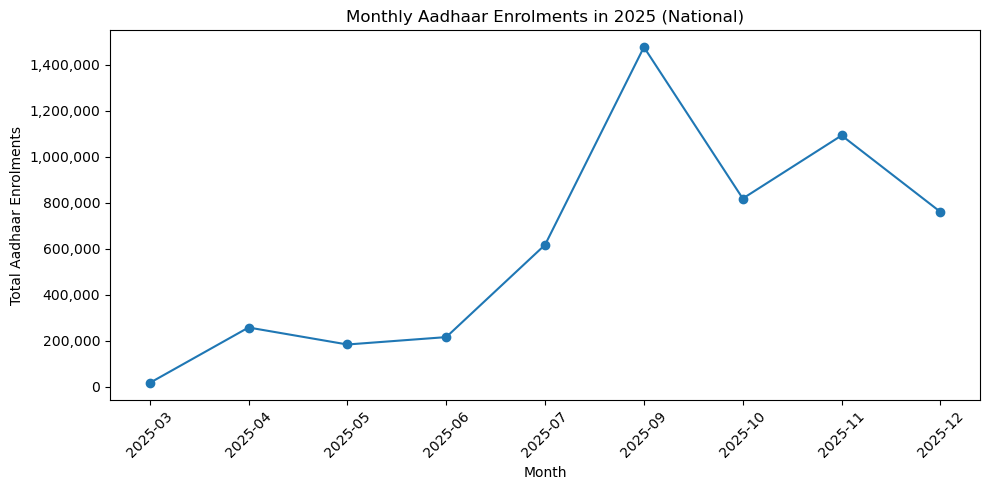

In [18]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_national["month"].astype(str),
    monthly_national["total_enrolments"],
    marker='o'
)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Aadhaar Enrolments")
plt.title("Monthly Aadhaar Enrolments in 2025 (National)")

# Force exact numbers on y-axis
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

In [19]:
# Group by state and sum age-group counts
state_age = (
    df.groupby("state")[["age_0_5", "age_5_17", "age_18_greater"]]
      .sum()
      .sort_values("age_18_greater", ascending=False)  # optional: show states with highest late enrolments first
)

state_age

,age_0_5,age_5_17,age_18_greater
state,,,
Meghalaya,21179,53305,35287
Assam,141235,66085,22877
Uttar Pradesh,521045,479682,17902
Gujarat,193031,71182,16336
Bihar,262875,334802,11908
Karnataka,179262,33863,10110
Madhya Pradesh,367990,116381,9599
West Bengal,275391,91396,8510
Maharashtra,278814,82116,8209


In [20]:
state_age_ratios = state_age.div(state_age.sum(axis=1), axis=0)
state_age_ratios

,age_0_5,age_5_17,age_18_greater
state,,,
Meghalaya,0.192938,0.485602,0.321460
Assam,0.613540,0.287080,0.099380
Uttar Pradesh,0.511516,0.470909,0.017575
Gujarat,0.688047,0.253724,0.058229
Bihar,0.431236,0.549229,0.019535
Karnataka,0.803019,0.151692,0.045289
Madhya Pradesh,0.744964,0.235603,0.019432
West Bengal,0.733795,0.243530,0.022675
Maharashtra,0.755309,0.222453,0.022238


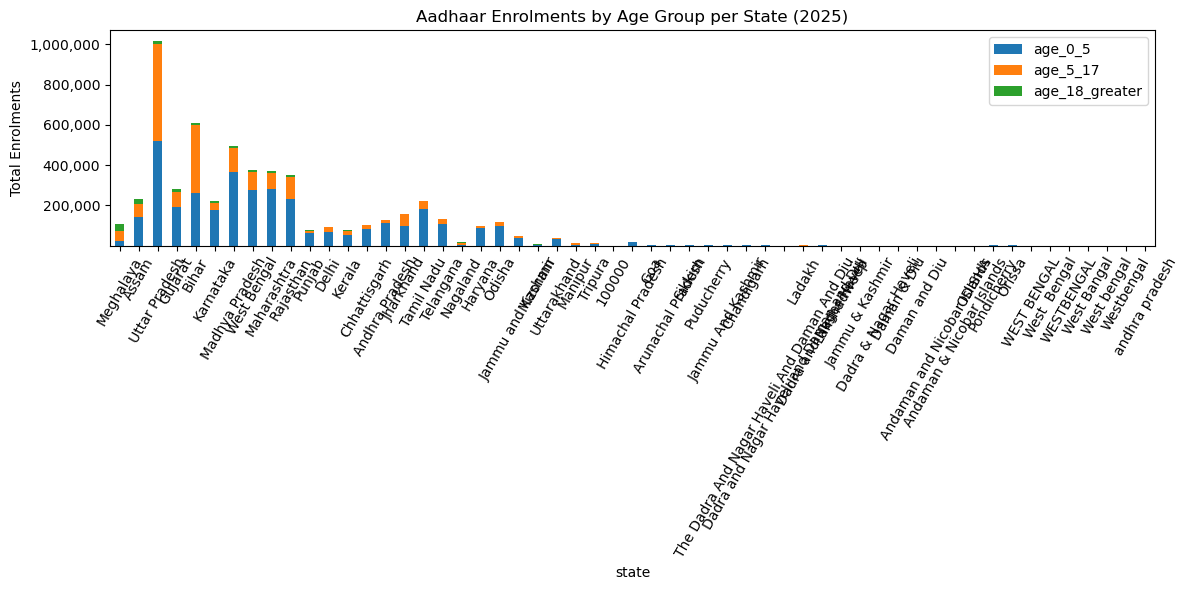

In [39]:
state_age.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6)
)
plt.ylabel("Total Enrolments")
plt.title("Aadhaar Enrolments by Age Group per State (2025)")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()
#not looking good at all, also make the names short